In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2

TEXT_DATA = 'data/fake_or_real_news.csv'

In [3]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    
    return train_acc, test_acc

In [4]:
# estimate 95% confidence interval on error

# NOTE: based on conversation on stackexchange: 
# https://stats.stackexchange.com/questions/247551/how-to-determine-the-confidence-of-a-neural-network-prediction
# towards bottom of the page.

from math import sqrt

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term
    
    return lb, ub

In [5]:
# read in our data and preprocess it

df = pd.read_csv(TEXT_DATA)
df.drop(labels=['id','title'], axis='columns', inplace=True)
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [6]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


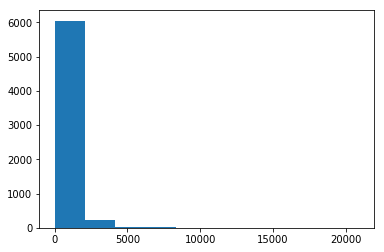

In [7]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

## Naive Bayes

In [8]:
# set up vector models for training and testing

from sklearn.feature_extraction.text import CountVectorizer

# data vectorizer
vectorizer = CountVectorizer(analyzer = "word", 
                             binary = True, 
                             min_df = 2,
                             stop_words='english')
docarray = vectorizer.fit_transform(texts).toarray()
docterm = pd.DataFrame(docarray, columns=vectorizer.get_feature_names())

In [9]:
# create training and test data

from sklearn.model_selection import train_test_split
docterm_train, docterm_test, y_train, y_test = train_test_split(docterm, labels, test_size=TEST_SPLIT)

In [10]:
# Naive Bayes Model

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(docterm_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [11]:
# evaluate model

train_acc, test_acc = evaluate_model(model.predict, docterm_train, y_train, docterm_test, y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 93.53%
Testing Accuracy: 89.98%


In [12]:
# estimate 95% confidence interval

n = docterm_test.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 88.32%-91.63%


## Convolutional DNN

In [13]:
# vectorize the text samples into a 2D integer tensor 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Using TensorFlow backend.


Found 98817 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [14]:
# split the data into a training set and a validation set   

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data, 
                                                  labels.apply(lambda x: 0 if x == 'FAKE' else 1), 
                                                  test_size=TEST_SPLIT)

In [15]:
# build a 1D convnet with global maxpooling                                                                      

from keras import layers
from keras.models import Sequential

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM, 
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        
        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 300)         7500300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4996, 128)         192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 7,709,069
Trainable params: 7,709,069
Non-trainable params: 0
_________________________________________________________________


In [16]:
# train the model

history = model.fit(x_train, 
                    y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Train on 5068 samples, validate on 1267 samples
Epoch 1/10
5068/5068 [==============================] - 24s 5ms/step - loss: 0.4608 - acc: 0.7873 - val_loss: 0.2281 - val_acc: 0.9171
Epoch 2/10
5068/5068 [==============================] - 19s 4ms/step - loss: 0.1346 - acc: 0.9617 - val_loss: 0.1744 - val_acc: 0.9266
Epoch 3/10
5068/5068 [==============================] - 19s 4ms/step - loss: 0.0371 - acc: 0.9935 - val_loss: 0.0941 - val_acc: 0.9590
Epoch 4/10
5068/5068 [==============================] - 19s 4ms/step - loss: 0.0060 - acc: 0.9998 - val_loss: 0.0909 - val_acc: 0.9597
Epoch 5/10
5068/5068 [==============================] - 19s 4ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0879 - val_acc: 0.9645
Epoch 6/10
5068/5068 [==============================] - 19s 4ms/step - loss: 1.9499e-04 - acc: 1.0000 - val_loss: 0.0857 - val_acc: 0.9684
Epoch 7/10
5068/5068 [==============================] - 19s 4ms/step - loss: 4.8268e-05 - acc: 1.0000 - val_loss: 0.0856 - val_acc: 0.9700

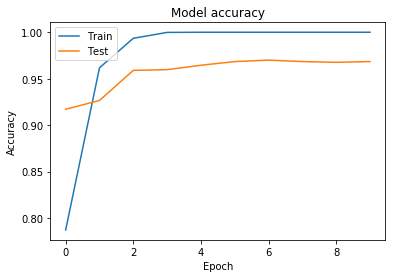

In [17]:
# Plot training & validation accuracy values

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
# evaluate model

def predict(X):
    return np.rint(model.predict(X)) # threshold the predictions to retrieve labels

train_acc, test_acc = evaluate_model(predict,
                                     x_train, 
                                     y_train, 
                                     x_val, 
                                     y_val)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 100.00%
Testing Accuracy: 96.84%


In [19]:
# estimate 95% confidence interval

n = x_val.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 95.88%-97.81%
